In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install rasterio

     |████████████████████████████████| 19.7MB 60.0MB/s 


In [0]:
import numpy as np
import rasterio
import random
import glob
import copy
import cv2
import os

from matplotlib import pyplot as plt

finaImageList1=[]
finaImageList2=[]
finaMaskList=[]

numberOfChannels=3
imageSize=512
numberOfImages=30
cropSize=224


def readData(imagesPath,maskPath):
	global finaImageList1
	global finaImageList2
	global finaMaskList

	global numberOfChannels
	global imageSize
	global numberOfImages
	
	imageFolderList=glob.glob(imagesPath+"/*")
	maskFolderList=glob.glob(maskPath+"/*")

	trainImageFolderList=imageFolderList[0:len(imageFolderList)-2]
	validImageFolderList=imageFolderList[len(imageFolderList)-2:]

	trainMaskFolderList=maskFolderList[0:len(maskFolderList)-2]
	validMaskFolderList=maskFolderList[len(maskFolderList)-2:]

	

	for currentImageFolder,currentMaskFolder in zip(trainImageFolderList,trainMaskFolderList):
		print("*"*80)
		print("CURRENT CITY: ",currentImageFolder.split("/")[-1])
		
		randomCropSingleImage(currentImageFolder,currentMaskFolder)
		
	finaTrainImageList1=np.array(finaImageList1)
	finaTrainImageList2=np.array(finaImageList2)
	finaTrainMaskList=np.array(finaMaskList)

	finaImageList1=[]
	finaImageList2=[]
	finaMaskList=[]

	

	print("+++++++++++++++++++++++++++++++++")
	for currentImageFolder,currentMaskFolder in zip(validImageFolderList,validMaskFolderList):
		print("*"*80)
		print("CURRENT CITY: ",currentImageFolder.split("/")[-1])
		
		randomCropSingleImage(currentImageFolder,currentMaskFolder)
		

	finaValidImageList1=np.array(finaImageList1)
	finaValidImageList2=np.array(finaImageList2)
	finaValidMaskList=np.array(finaMaskList)
	print("________TRAIN DATA_________")
	print(finaTrainImageList1.shape)
	print(finaTrainImageList2.shape)
	print(finaTrainMaskList.shape)
	print("________VALIDATION DATA_________")
	print(finaValidImageList1.shape)
	print(finaValidImageList2.shape)
	print(finaValidMaskList.shape)


	return finaTrainImageList1,finaTrainImageList2,finaTrainMaskList,finaValidImageList1,finaValidImageList2,finaValidMaskList


def readMultiChannelImages(imageFolder):
	global numberOfChannels
	global imageSize

	
	
	image1=np.zeros((imageSize,imageSize)).astype(int)
	image2=np.zeros((imageSize,imageSize)).astype(int)
	
	bandList=['B08','B02','B03','B04','B05','B06','B07','B01','B11','B12','B8A']
	for currentChannel in range(numberOfChannels):
		print("/"*80)
		bandName=bandList[currentChannel]
		print(bandName)
	
		imagePath1=imageFolder+"/imgs_1/"+bandName+".tif"
		imagePath2=imageFolder+"/imgs_2/"+bandName+".tif"
	
	
		singleChannelData1=rasterio.open(imagePath1)
		singleChannelData2=rasterio.open(imagePath2)
		singleChannelImage1=singleChannelData1.read()[0]
		singleChannelImage2=singleChannelData2.read()[0]
		
		mean,std=bandMeanStd(bandName)
		singleChannelImage1=(singleChannelImage1-mean)/std
		singleChannelImage2=(singleChannelImage2-mean)/std

		

		singleChannelImage1=_resize(singleChannelImage1,imageSize,imageSize)
		singleChannelImage2=_resize(singleChannelImage2,imageSize,imageSize)

		
		image1=np.dstack((image1,singleChannelImage1))
		image2=np.dstack((image2,singleChannelImage2))

		
		
			
	image1=np.delete(image1,0,2)
	image2=np.delete(image2,0,2)
	if(numberOfChannels==1):
		image1=image1.reshape((imageSize,imageSize))
		image2=image2.reshape((imageSize,imageSize))
	
	image1=image1.astype("uint8")
	image2=image2.astype("uint8")
	
	
	return image1,image2
		




def randomCropSingleImage(currentImageFolder,currentMaskFolder):
	global numberOfChannels
	global imageSize
	global numberOfImages
	global cropSize
	
	image1,image2=readMultiChannelImages(currentImageFolder)

	maskData=rasterio.open(currentMaskFolder+"/cm/"+str(currentMaskFolder.split("/")[-1])+"-cm.tif")
	maskImage=maskData.read()[0]



	maskImage=cv2.resize(maskImage,(imageSize,imageSize))
	cv2.normalize(maskImage, maskImage, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
	crop_new=int(cropSize/2)
	


	x=[random.randrange(crop_new,imageSize-crop_new) for i in range(numberOfImages)]
	y=[random.randrange(crop_new,imageSize-crop_new) for i in range(numberOfImages)]    

	global finaImageList1
	global finaImageList2
	global finaMaskList
	

	for j in range(numberOfImages):
		
		tempImage1=image1.copy()
		tempImage1=tempImage1[y[j]-crop_new:y[j]+crop_new,x[j]-crop_new:x[j]+crop_new]
		finaImageList1.append(tempImage1)

		tempImage2=image2.copy()
		tempImage2=tempImage2[y[j]-crop_new:y[j]+crop_new,x[j]-crop_new:x[j]+crop_new]
		finaImageList2.append(tempImage2)
		
		tempMaskImage=maskImage.copy()
		tempMaskImage=tempMaskImage[y[j]-crop_new:y[j]+crop_new,x[j]-crop_new:x[j]+crop_new]
		finaMaskList.append(tempMaskImage)

	del(image1)
	del(image2)	
	
	return 
		


def viewImages(imageTensor1,imageTensor2,maskTensor,outputMask):

  image1=np.transpose(imageTensor1.cpu().detach().numpy(),(1,2,0))
  image2=np.transpose(imageTensor2.cpu().detach().numpy(),(1,2,0))
  
  maskImage=(maskTensor.cpu().detach().numpy()).reshape((cropSize,cropSize))
  
  outputMaskImage=(outputMask.cpu().detach().numpy()).reshape((cropSize,cropSize))
  
  print(image1.shape)
  print(image2.shape)
  print(maskImage.shape)
  
  image1=image1[:,:,1]
  image2=image2[:,:,1]
  

  
  
  plt.figure()
  plt.imshow(image1)
  
  plt.figure()
  plt.imshow(image2)
  
  plt.figure()
  plt.imshow(maskImage)
  
  plt.figure()
  plt.imshow(outputMaskImage)
  
  
  plt.show()
  
  
def bandMeanStd(bandName):
	band_means = {'B01':1570.3328515405854,
				'B02': 1365.2243773846644,
				'B03': 1284.4517605356245,
				'B04': 1298.5500317225392,
				'B05': 1430.6306294436106,
				'B06': 1860.2585705690433,
				'B07': 2081.1334118974587,
				'B08': 1994.0279905119721,
				'B09': 641.3308644909532,
				'B10': 14.330245437938553,
				'B11': 1956.5497093158071,
				'B12': 1419.0062341462785,
				'B8A': 2213.7314071301703}

	band_stds = {'B01': 275.91376611027414,
			 	'B02': 414.55141334575075,
				'B03': 537.4036918825575,
				'B04': 765.132896049722,
				'B05': 726.4114113353035,
				'B06': 763.2208613392219,
				'B07': 852.3189864292991,
				'B08': 866.6840698014917,
				'B09': 323.13120825406384,
				'B10': 8.634058144212835,
				'B11': 1020.3849306463397,
				'B12': 873.419126071941,
				'B8A': 923.7889905918561}


	for currentBandName,currentMean in band_means.items():
		if(currentBandName==bandName):
			bandMean=currentMean

	for currentBandName,currentStd in band_stds.items():
		if(currentBandName==bandName):
			bandStd=currentStd
	return bandMean,bandStd


def _resize(band, height, width):
	band = cv2.resize(band, (height, width))
	band = stretch_8bit(band)
	return band


def stretch_8bit(band, lower_percent=2, higher_percent=98):
	a = 0
	b = 255

	real_values = band.flatten()
	real_values = real_values[real_values > 0]
	c = np.percentile(real_values, lower_percent)
	d = np.percentile(real_values, higher_percent)
	t = a + (band - c) * ((b - a) / (d - c))
	t[t < a] = a
	t[t > b] = b
	return t.astype(np.uint8)


def divideTestImages(imageFolder,maskFolder):
	global numberOfChannels
	global imageSize
	global numberOfImages
	global cropSize
	
	image1,image2=readMultiChannelImages(imageFolder)
	
	maskData=rasterio.open(maskFolder+"/cm/"+str(maskFolder.split("/")[-1])+"-cm.tif")
	maskImage=maskData.read()[0]

	maskImage=cv2.resize(maskImage,(imageSize,imageSize))
	cv2.normalize(maskImage, maskImage, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)


	totalNumberImages=int(imageSize/cropSize)
	print("TOTAL NUMBER OF IMAGES: ",totalNumberImages)
	
	print(image1.shape)
	print(image2.shape)
	print(maskImage.shape)
	
	
	imageList1=[]
	imageList2=[]
	maskList=[]

	k=0

	for i in range(totalNumberImages):
		l=0
		for j in range(totalNumberImages):
			tempImage1=image1.copy()
			tempImage1=tempImage1[l:l+cropSize,k:k+cropSize,:]
			imageList1.append(tempImage1)
			
			tempImage2=image2.copy()
			tempImage2=tempImage2[l:l+cropSize,k:k+cropSize,:]
			imageList2.append(tempImage2)
			
			tempMaskImage=maskImage.copy()
			tempMaskImage=tempMaskImage[l:l+cropSize,k:k+cropSize]
			maskList.append(tempMaskImage)
			l=l+cropSize
		k=k+cropSize
	del(image1)
	del(image2)
	
	return np.array(imageList1),np.array(imageList2),np.array(maskList)




def joinTestImages(outputImagesList):

	global numberOfChannels
	global numberOfImages
	global imageSize
	global cropSize
	totalNumberImages=int(imageSize/cropSize)
	finalOutputImage=np.zeros((imageSize,1))
	print(finalOutputImage.shape)
	k=0
	for i in range(totalNumberImages):
		rowImage=outputImagesList[k]
		
		for j in range(1,totalNumberImages):
			rowImage=np.concatenate((rowImage,outputImagesList[k+j]))
		
		finalOutputImage=np.concatenate((finalOutputImage,rowImage),1)
		
		
		k=k+totalNumberImages
		

	finalOutputImage=np.delete(finalOutputImage,0,1)
	return finalOutputImage

        



In [0]:
imagesPath="/content/drive/My Drive/CV_Project/data/Onera Satellite Change Detection dataset - Images"
maskPath="/content/drive/My Drive/CV_Project/data/Onera Satellite Change Detection dataset - Train Labels"

finaTrainImageList1,finaTrainImageList2,finaTrainMaskList,finaValidImageList1,finaValidImageList2,finaValidMaskList=readData(imagesPath,maskPath)


********************************************************************************
CURRENT CITY:  abudhabi
////////////////////////////////////////////////////////////////////////////////
B08
////////////////////////////////////////////////////////////////////////////////
B02
////////////////////////////////////////////////////////////////////////////////
B03
********************************************************************************
CURRENT CITY:  beihai
////////////////////////////////////////////////////////////////////////////////
B08


/usr/local/lib/python3.6/dist-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)


////////////////////////////////////////////////////////////////////////////////
B02
////////////////////////////////////////////////////////////////////////////////
B03
********************************************************************************
CURRENT CITY:  saclay_e
////////////////////////////////////////////////////////////////////////////////
B08
////////////////////////////////////////////////////////////////////////////////
B02
////////////////////////////////////////////////////////////////////////////////
B03
********************************************************************************
CURRENT CITY:  bordeaux
////////////////////////////////////////////////////////////////////////////////
B08
////////////////////////////////////////////////////////////////////////////////
B02
////////////////////////////////////////////////////////////////////////////////
B03
********************************************************************************
CURRENT CITY:  paris
////////

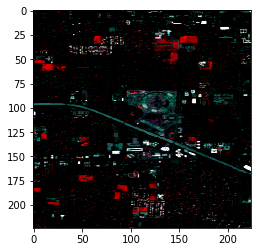

In [0]:
plt.imshow(finaImageList1[0])

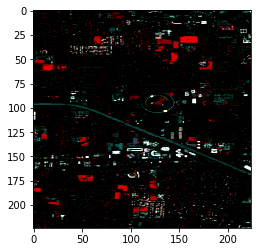

In [0]:
plt.imshow(finaImageList2[0])

In [0]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Variable
from PIL import Image
import numpy as np
import torchvision
import pandas as pd
import torch
import cv2
import pickle


inputImageTranform = transforms.Compose([transforms.ToTensor()])








class readTrainDataset(Dataset):
	def __init__(self, images1,images2, maskImages, inputImageTranform):

		self.images1 = images1
		self.images2 = images2
		self.maskImages = maskImages

			
		self.inputImageTranform = inputImageTranform
	   

	def __len__(self):
		return len(self.images1)

	def __getitem__(self, idx):
			
		currentImage1 = self.images1[idx]
		currentImage1=Image.fromarray(currentImage1)

		currentImage2 = self.images2[idx]
		currentImage2=Image.fromarray(currentImage2)
			

		currentMaskImage=self.maskImages[idx]
			
		currentMaskImage=Image.fromarray(currentMaskImage)

	
		if self.inputImageTranform is not None:
			currentImage1 = self.inputImageTranform(currentImage1)
			currentImage1 = Variable(currentImage1)

			currentImage2 = self.inputImageTranform(currentImage2)
			currentImage2 = Variable(currentImage2)
			

			currentMaskImage = self.inputImageTranform(currentMaskImage)
			currentMaskImage = Variable(currentMaskImage)
			

		return (currentImage1,currentImage2, currentMaskImage)






def trainDataLoaderFn(images1,images2, maskImages):

	trainSet = readTrainDataset(images1,images2, maskImages, inputImageTranform)
	
	return DataLoader(trainSet, batch_size=1, shuffle=True, num_workers=2)




In [0]:
from torch import nn
from torch.nn import functional as F
import torch
from torchvision import models
import torchvision
from torchsummary import summary



def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)


class ConvRelu(nn.Module):
    def __init__(self, in_, out):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x



class Interpolate(nn.Module):
    def __init__(self, size=None, scale_factor=None, mode='nearest', align_corners=False):
        super(Interpolate, self).__init__()
        self.interp = nn.functional.interpolate
        self.size = size
        self.mode = mode
        self.scale_factor = scale_factor
        self.align_corners = align_corners
        
    def forward(self, x):
        x = self.interp(x, size=self.size, scale_factor=self.scale_factor, 
                        mode=self.mode, align_corners=self.align_corners)
        return x


class DecoderBlockV2(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, is_deconv=True):
        super(DecoderBlockV2, self).__init__()
        self.in_channels = in_channels

        if is_deconv:
            """
                Paramaters for Deconvolution were chosen to avoid artifacts, following
                link https://distill.pub/2016/deconv-checkerboard/
            """

            self.block = nn.Sequential(
                ConvRelu(in_channels, middle_channels),
                nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=4, stride=2,
                                   padding=1),
                nn.ReLU(inplace=True)
            )
        else:
            self.block = nn.Sequential(
                Interpolate(scale_factor=2, mode='bilinear'),
                ConvRelu(in_channels, middle_channels),
                ConvRelu(middle_channels, out_channels),
            )

    def forward(self, x):
        return self.block(x)



class UNet16(nn.Module):
    def __init__(self, num_classes=1, num_filters=32, pretrained=True, is_deconv=True):
        """
        :param num_classes:
        :param num_filters:
        :param pretrained:
            False - no pre-trained network used
            True - encoder pre-trained with VGG16
        :is_deconv:
            False: bilinear interpolation is used in decoder
            True: deconvolution is used in decoder
        """
        super().__init__()
        self.num_classes = num_classes

        self.pool = nn.MaxPool2d(2, 2)

        self.encoder = torchvision.models.vgg16(pretrained=pretrained).features

        self.relu = nn.ReLU(inplace=False)

        self.conv1 = nn.Sequential(self.encoder[0],
                                   self.relu,
                                   self.encoder[2],
                                   self.relu)

        self.conv2 = nn.Sequential(self.encoder[5],
                                   self.relu,
                                   self.encoder[7],
                                   self.relu)

        self.conv3 = nn.Sequential(self.encoder[10],
                                   self.relu,
                                   self.encoder[12],
                                   self.relu,
                                   self.encoder[14],
                                   self.relu)

        self.conv4 = nn.Sequential(self.encoder[17],
                                   self.relu,
                                   self.encoder[19],
                                   self.relu,
                                   self.encoder[21],
                                   self.relu)

        self.conv5 = nn.Sequential(self.encoder[24],
                                   self.relu,
                                   self.encoder[26],
                                   self.relu,
                                   self.encoder[28],
                                   self.relu)

        self.center = DecoderBlockV2(512, num_filters * 8 * 2, num_filters * 8, is_deconv)

        self.dec5 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec4 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec3 = DecoderBlockV2(256 + num_filters * 8, num_filters * 4 * 2, num_filters * 2, is_deconv)
        self.dec2 = DecoderBlockV2(128 + num_filters * 2, num_filters * 2 * 2, num_filters, is_deconv)
        self.dec1 = ConvRelu(64 + num_filters, num_filters)
        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(self.pool(conv1))
        conv3 = self.conv3(self.pool(conv2))
        conv4 = self.conv4(self.pool(conv3))
        conv5 = self.conv5(self.pool(conv4))

        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))

        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))

        if self.num_classes > 1:
            x_out = F.log_softmax(self.final(dec1), dim=1)
        else:
            x_out = self.final(dec1)

        return x_out



In [0]:
class SiameseUnet(UNet16):
  def forward(self,x1,x2):
    outputX1=super().forward(x1)
    outputX2=super().forward(x2)
    
    resultImage = torch.sigmoid(outputX1-outputX2)
    return resultImage


In [0]:
import os


class configClass():
    def __init__(self):


        self.epochs=200
        self.batch_size = 128       # of images in each batch of data
        self.num_workers = 2       # of subprocesses to use for data loading
        self.shuffle = True        # Whether to shuffle the dataset between epochs')
        self.augment = True        # Whether to use data augmentation for train data
        self.lr=0.01
        self.momentum = 0.9
        self.weightDecay=0.0005
        self.trainPaitence=5

        
        self.num_model = 1  # Model number used for unique checkpointing
        self.use_gpu = True  # Whether to run on the GPU
        self.random_seed = 42  # Seed to ensure reproducibility
        self.ckpt_dir = './ckpt/'  # Directory in which to save model checkpoints
        self.resume=False

In [0]:
import torch.backends.cudnn as cudnn
from torchsummary import summary
from tqdm import tqdm
from torch import optim
import torch.nn as nn
import numpy as np
import torch
import sys
import os
import time

class modelClass():
	def __init__(self,trainLoader,validLoader,config):

		self.config=config
		self.trainLoader=trainLoader
		self.validLoader = validLoader
		self.numTrain=len(self.trainLoader.dataset)
		self.numValid=len(self.validLoader.dataset)


		self.useGpu=self.config.use_gpu
		if(self.useGpu):
			torch.cuda.manual_seed(config.random_seed)
			self.device = 'cuda'
		else:
			self.device = 'cpu'

		self.net=SiameseUnet()
		self.net = self.net.to(self.device)
		if self.device == 'cuda':
			self.net = torch.nn.DataParallel(self.net)
			cudnn.benchmark = True

		self.bestValidLoss = np.inf
		self.startEpoch = 0
		self.totalEpochs=config.epochs


		self.optimizer = optim.SGD(self.net.parameters(),lr=self.config.lr,momentum=self.config.momentum,weight_decay=self.config.weightDecay)
		self.criterion = nn.BCELoss()

		self.batchSize=config.batch_size
		self.trainPaitence=config.trainPaitence

		self.ckpt_dir = config.ckpt_dir

		if not os.path.exists(self.ckpt_dir):
			os.makedirs(self.ckpt_dir)



	def train(self):

		print("\n[*] Train on {} sample pairs, validate on {} trials".format(self.numTrain, self.numValid))


		for epoch in range (self.startEpoch,self.totalEpochs):
			print('\nEpoch: {}/{}'.format(epoch+1, self.totalEpochs))

			self.trainOneEpoch(epoch)
			validationLoss=self.validOneEpoch(epoch)

			if(validationLoss<self.bestValidLoss):
				print("SAVING MODEL..")
				self.bestValidLoss=validationLoss
				self.counter=0
				self.saveCheckPoint(
						{
							'epoch': epoch + 1,
							'model_state': self.net.state_dict(),
							'optim_state': self.optimizer.state_dict(),
							'best_valid_loss': self.bestValidLoss,
						}
					)

			else:
				self.counter+=1

			if(self.counter>self.trainPaitence):
				print("STOPPING TRAINING NO IMPROVEMENT!!!")
				return

		return


	def trainOneEpoch(self,epoch):
		self.net.train()
		train_loss = 0


		tic=time.time()
		with tqdm(total=self.numTrain) as pbar:

			for batch_idx, (inputImage1,inputImage2, targetImage) in enumerate(self.trainLoader):
				inputImage1, inputImage2, targetImage = inputImage1.to(self.device),inputImage2.to(self.device) ,targetImage.to(self.device)
					
				self.optimizer.zero_grad()
				
		  

				outputImage = self.net(inputImage1,inputImage2)

				outputImageFlatten=outputImage.view(-1)
				targetImageFlatten=targetImage.view(-1)
				loss = self.criterion(outputImageFlatten, targetImageFlatten)
				loss.backward()
				self.optimizer.step()
				toc=time.time()

				train_loss += loss.item()
				currentTrainLoss=loss.item()

				pbar.set_description(
					(
						"{:.1f}s - loss: {:.3f}".format(
							currentTrainLoss,
							toc-tic,
						)
					)
				)
				tic=time.time()
				pbar.update(self.batchSize)
				del(inputImage1)
				del(inputImage2)
				del(targetImage)
				

		avgLoss=train_loss/len(self.trainLoader.dataset)
		print("[INFO]:TRAIN AVGERAGE LOSS:",avgLoss)

		return avgLoss




	def validOneEpoch(self,epoch):
		self.net.eval()
		validationLoss = 0


		tic=time.time()
		with tqdm(total=self.numTrain) as pbar:
			with torch.no_grad():

				for batch_idx, (inputImage1,inputImage2, targetImage) in enumerate(self.validLoader):
					
					inputImage1, inputImage2, targetImage = inputImage1.to(self.device),inputImage2.to(self.device) ,targetImage.to(self.device)
					
					outputImage = self.net(inputImage1,inputImage2)
					

					outputImageFlatten=outputImage.view(-1)
					targetImageFlatten=targetImage.view(-1)
					loss = self.criterion(outputImageFlatten, targetImageFlatten)


					validationLoss += loss.item()
					currentValidationLoss=loss.item()
					toc=time.time()

					pbar.set_description(
						(
							"{:.1f}s - loss: {:.3f}".format(
								currentValidationLoss,
								toc-tic,
							)
						)
					)
					tic=time.time()
					pbar.update(self.batchSize)

		avgLoss=validationLoss/len(self.validLoader.dataset)
		print("[INFO]:VALIDATION AVGERAGE LOSS:",avgLoss)

		return avgLoss
  
		
		
		
	def testModel(self,inputImage1,inputImage2):
		self.net.eval()
		with torch.no_grad():
			inputImage1, inputImage2 = inputImage1.to(self.device),inputImage2.to(self.device)
			outputImage = self.net(inputImage1,inputImage2)

		return outputImage

	  



	def saveCheckPoint(self,state):
		filename = 'model_ckpt.tar'
		ckptPath = os.path.join(self.ckpt_dir, filename)
		torch.save(state, ckptPath)

	
	def loadCheckpoint(self):
		print("[*] Loading model from {}".format(self.ckpt_dir))
		fileName='model_ckpt.tar'
		ckpt_path = os.path.join(self.ckpt_dir, fileName)
		if(self.useGpu==False):
			self.ckpt = torch.load(ckpt_path,map_location=lambda storage, loc: storage)
			model_state=(self.ckpt['model_state'])
		
			new_state_dict = OrderedDict()
		
			for k, v in model_state.items():
				name = k[7:] 
				new_state_dict[name]=v

			self.net.load_state_dict(new_state_dict)

		else:
			self.ckpt = torch.load(ckpt_path)
			self.net.load_state_dict(self.ckpt['model_state'])
		
		return self.net




In [0]:

trainLoader=trainDataLoaderFn(finaTrainImageList1,finaTrainImageList2,finaTrainMaskList)
validLoader=trainDataLoaderFn(finaValidImageList1,finaValidImageList2,finaValidMaskList)
configObject=configClass()

In [0]:
temp=iter(trainLoader)

In [0]:
print(temp.next()[0].shape)

torch.Size([1, 3, 224, 224])


In [0]:
modelObject=modelClass(trainLoader,validLoader,configObject)

In [0]:
modelObject.train()

  0%|          | 0/360 [00:00<?, ?it/s]


[*] Train on 360 sample pairs, validate on 60 trials

Epoch: 1/200


0.7s - loss: 0.046: : 46080it [00:41, 1171.29it/s]
  0%|          | 0/360 [00:00<?, ?it/s]

[INFO]:TRAIN AVGERAGE LOSS: 0.6735242367618614


0.5s - loss: 0.034: : 7680it [00:02, 3113.91it/s]


[INFO]:VALIDATION AVGERAGE LOSS: 0.6623682161172231
SAVING MODEL..


  0%|          | 0/360 [00:00<?, ?it/s]


Epoch: 2/200


0.7s - loss: 0.045: : 46080it [00:38, 1209.70it/s]
  0%|          | 0/360 [00:00<?, ?it/s]

[INFO]:TRAIN AVGERAGE LOSS: 0.6048950869176123


0.7s - loss: 0.034: : 7680it [00:02, 3233.95it/s]
  0%|          | 0/360 [00:00<?, ?it/s]

[INFO]:VALIDATION AVGERAGE LOSS: 0.684142146507899

Epoch: 3/200


0.6s - loss: 0.048: : 46080it [00:38, 1196.29it/s]
  0%|          | 0/360 [00:00<?, ?it/s]

[INFO]:TRAIN AVGERAGE LOSS: 0.5654368682867951


0.7s - loss: 0.034: : 7680it [00:02, 3230.85it/s]
  0%|          | 0/360 [00:00<?, ?it/s]

[INFO]:VALIDATION AVGERAGE LOSS: 0.6933423439661662

Epoch: 4/200


0.7s - loss: 0.045: : 46080it [00:38, 1215.45it/s]
  0%|          | 0/360 [00:00<?, ?it/s]

[INFO]:TRAIN AVGERAGE LOSS: 0.4991315753664821


0.7s - loss: 0.035: : 7680it [00:02, 3196.99it/s]
  0%|          | 0/360 [00:00<?, ?it/s]

[INFO]:VALIDATION AVGERAGE LOSS: 0.7177720646063487

Epoch: 5/200


0.8s - loss: 0.048: : 46080it [00:38, 1199.97it/s]
  0%|          | 0/360 [00:00<?, ?it/s]

[INFO]:TRAIN AVGERAGE LOSS: 0.539295829149584


0.9s - loss: 0.035: : 7680it [00:02, 3110.26it/s]
  0%|          | 0/360 [00:00<?, ?it/s]

[INFO]:VALIDATION AVGERAGE LOSS: 0.7172528520226479

Epoch: 6/200


0.1s - loss: 0.045: : 46080it [00:38, 1195.22it/s]
  0%|          | 0/360 [00:00<?, ?it/s]

[INFO]:TRAIN AVGERAGE LOSS: 0.39822696132533664


0.9s - loss: 0.035: : 7680it [00:02, 3193.36it/s]
  0%|          | 0/360 [00:00<?, ?it/s]

[INFO]:VALIDATION AVGERAGE LOSS: 0.9181843449672064

Epoch: 7/200


0.6s - loss: 0.047: : 46080it [00:38, 1203.98it/s]
  0%|          | 0/360 [00:00<?, ?it/s]

[INFO]:TRAIN AVGERAGE LOSS: 0.4134277440271237


0.6s - loss: 0.033: : 7680it [00:02, 3195.00it/s]

[INFO]:VALIDATION AVGERAGE LOSS: 0.6685475061337153
STOPPING TRAINING NO IMPROVEMENT!!!


In [0]:
temp=iter(trainLoader)

In [0]:
net=modelObject.loadCheckpoint()

[*] Loading model from ./ckpt/


In [0]:
device = 'cuda'
def testModel(inputImage1,inputImage2):
  net.eval()
  with torch.no_grad():
    inputImage1, inputImage2 = inputImage1.to(device),inputImage2.to(device)
    outputImage = net(inputImage1,inputImage2)

  return outputImage

In [0]:
testImage1,testImage2,testTargetImage=temp.next()

In [0]:
outputMask=testModel(testImage1,testImage2)

In [0]:
outputMask.shape

torch.Size([1, 1, 128, 128])

(128, 128, 3)
(128, 128, 3)
(128, 128)


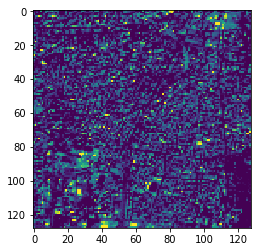

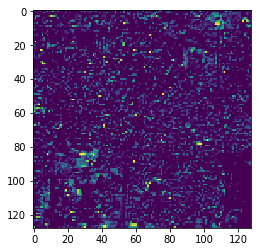

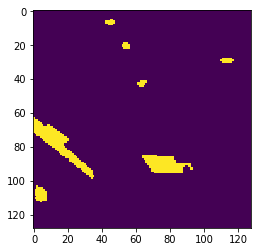

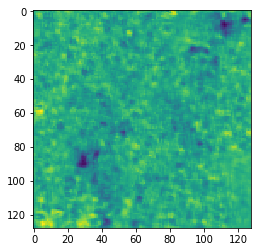

In [0]:
viewImages(testImage1[0],testImage2[0],testTargetImage[0],outputMask[0])

In [0]:
testCityPath="/content/drive/My Drive/CV_Project/data/Onera Satellite Change Detection dataset - Images/mumbai"
testMaskPath="/content/drive/My Drive/CV_Project/data/Onera Satellite Change Detection dataset - Train Labels/mumbai"


In [0]:
images1,images2,maskImages=divideTestImages(testCityPath,testMaskPath)


////////////////////////////////////////////////////////////////////////////////
B08
////////////////////////////////////////////////////////////////////////////////
B02
////////////////////////////////////////////////////////////////////////////////
B03
TOTAL NUMBER OF IMAGES:  4
(512, 512, 3)
(512, 512, 3)
(512, 512)


/usr/local/lib/python3.6/dist-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)


In [0]:
print(np.array(images1).shape)

(16, 128, 128, 3)


In [0]:
images1.shape

In [0]:

testLoader=trainDataLoaderFn(images1,images2,maskImages)

In [0]:
outputImageList=[]
for batch_idx, (inputImage1,inputImage2, targetImage) in enumerate(testLoader):
  
  outputImage=modelObject.testModel(inputImage1,inputImage2)
  outputImage=(outputImage.cpu().detach().numpy()).reshape((cropSize,cropSize))
  
  print(outputImage.shape)
  outputImageList.append(outputImage)
  


(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)


In [0]:
np.array(outputImageList).shape

(16, 128, 128)

In [0]:
finalImage=joinTestImages(outputImageList)

(512, 1)


In [0]:
finalTargetImage=joinTestImages(maskImages)

(512, 1)


In [0]:
finalImage.shape

(512, 512)

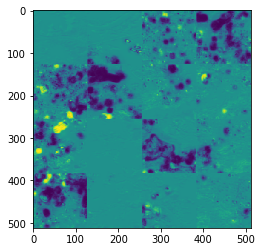

In [0]:
plt.imshow(finalImage)

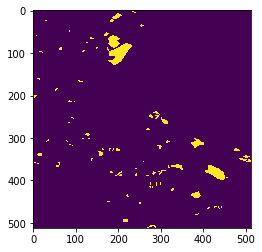

In [0]:
plt.imshow(finalTargetImage)